In [1]:
# import modules as usual
import os
import glob

import numpy as np

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# path of files
path_positive = '../eskin_data/yamamoto/throw/'
path_negative = '../eskin_data/yamamoto/others/'

In [3]:
# extract the moment of throwing based on accel values
def extract_action(df):
    df = df.reset_index()
    
    mom_action = int((np.argmax(abs(df.accelX))+ np.argmax(abs(df.accelY))+ np.argmax(abs(df.accelZ)))/3)
    df = df.ix[mom_action-90:mom_action+90] 
    
    df.index = df.time
    df.drop(["time"], axis=1, inplace=True)
    
    return df.as_matrix()

In [4]:
def load_positive_data(path):
    path = os.path.join(path_positive, '*.csv')
    files = glob.glob(path)
    
    X_positives = []
    
    for file_path in files:
        df = pd.read_csv(file_path, index_col=0)
        
        df = extract_action(df)
        
        X_positives.append(df)
        
    X_positives = np.array(X_positives)
    y_positives = np.ones(len(X_positives))
        
    return X_positives, y_positives

In [5]:
def load_negative_data(path, num_clip=100, random_state=71):
    np.random.seed(random_state)
    
    path = os.path.join(path, '*.csv')
    files = glob.glob(path)
    
    X_negatives = []
    
    for file_path in files:
        df = pd.read_csv(file_path, index_col=0)
        
        for i in range(num_clip):
            start = np.random.choice(range(len(df)-180))
            
            df_extracted = df.iloc[start:start+180].as_matrix()
            X_negatives.append(df_extracted)
        
    X_negatives = np.array(X_negatives)
    y_negatives = np.zeros(len(X_negatives))
        
    return X_negatives, y_negatives

In [6]:
def resize_matrix(X, size = (20, 20), flatten=False):
    X_resized = []
    
    for i in range(len(X)):
        X_ = X[i] /1.
        X_ = cv2.resize(X_, size, interpolation = cv2.INTER_LINEAR)
    
        if flatten == True: # True for XGBoost etc., False for CNN (Convolutional Newral Networks) 
            X_ = X_.ravel()
            
        X_resized.append(X_)
        
    X_resized = np.array(X_resized)
    
    return X_resized

In [7]:
X_positives, y_positives = load_positive_data(path_positive)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [8]:
X_negatives, y_negatives = load_negative_data(path_negative, num_clip=500)  # random 500 clops from negative data

In [9]:
# check the shape of positive data
X_positives.shape, y_positives.shape

((100, 181, 20), (100,))

In [10]:
# check the shape of negative data
X_negatives.shape, y_negatives.shape

((2000, 180, 20), (2000,))

In [11]:
X_positives = resize_matrix(X_positives, flatten=True)

In [12]:
X_negatives = resize_matrix(X_negatives, flatten=True)

In [13]:
X = np.concatenate((X_positives, X_negatives), axis=0)
y = np.concatenate((y_positives, y_negatives), axis=0)

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
scores = []

for i, (train, test) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    
    clf_xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, 
                            gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, 
                            min_child_weight=1, missing=None, n_estimators=100, nthread=-1, 
                            objective='binary:logistic', reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, seed=0, silent=True, subsample=0.7)
    
    clf_xgb.fit(X_train, y_train)
    probs = clf_xgb.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, probs)
    
    print(i, score)
    scores.append(score)
    
print("Total ROC-AUC:", np.array(scores).mean())

(0, 1.0)
(1, 1.0)
(2, 1.0)
(3, 1.0)
(4, 0.99637500000000001)
('Total ROC-AUC:', 0.99927500000000014)


In [15]:
df_ref = pd.read_csv("../eskin_data/yamamoto/throw/eskin131418286838246619.csv", index_col=0)

In [16]:
clf_xgb.fit(X, y)

feature_importance = clf_xgb.feature_importances_

In [17]:
df_imp = DataFrame(feature_importance.reshape(20,20), index=[str(x * 0.15) + "_msec" for x in range(20)], columns=df_ref.columns)

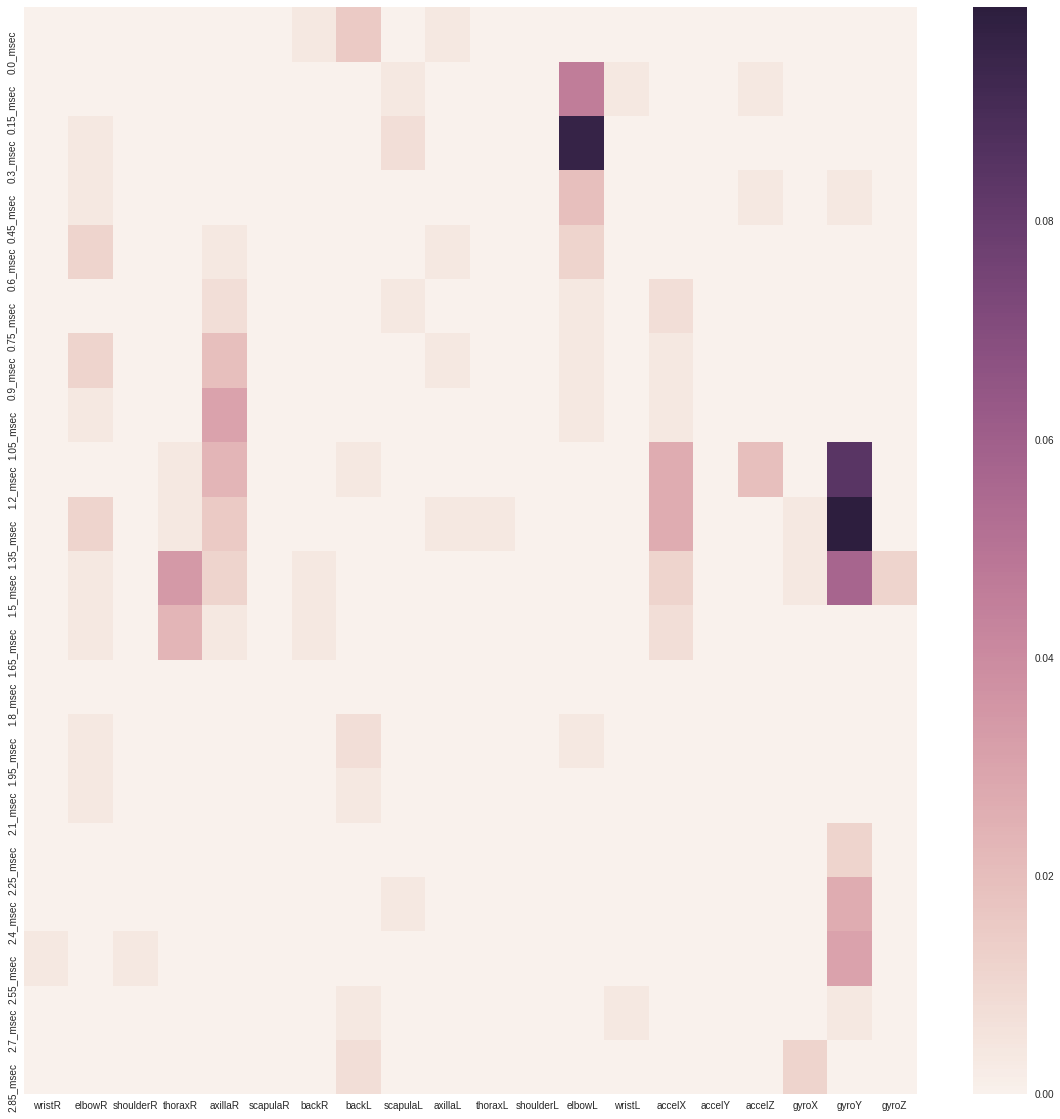

In [18]:
# show heatmap of feature importances.
plt.figure(figsize=[20,20])
sns.heatmap(df_imp)
plt.show()